# The HFM library - A fast marching solver with adaptive stencils

## Part : Applications
## Chapter : Closed path through a keypoint

In this notebook, we compute paths from a point to itself, going through an intermediate keypoint, and minimizing a given cost. Paths are subject to a penalization of curvature, and the path tangent at the extremal and intermediate endpoints is free. From a mathematical standpoint, these 'points' should thus be regarded as subdomains $\{p\} \times S^1$ within the position-orientation space $R^2 \times S^1$ where the eikonal equation is solved.

Some experiments model an intruder entering a domain, visiting a presecribed point, and then leaving that domain, while minimizing the probability of detection by a (static) surveillance system. The parameters of the surveillance system are then adjusted to improve the probability of detection. 

The purpose of this notebook is to illustrate:
* the computation of optimal paths with an intermediate keypoint or region.
* the various curvature penalization models - Reeds-Shepp, Euler, Dubins available in the HFM library.
* the use of automatic differentiation to optimize a complex objective function, by projected gradient descent.

**Mathematical formulation of the closed loop problem**

Consider a domain $\Omega$, and sub-domains $\Omega_0, \Omega_1, \Omega_2$. We look for the path of minimal cost from the  start region $\Omega_0$, through the intermediate (keypoint) region $\Omega_1$, finishing in the end region $\Omega_2$. Namely we solve
$$
    \min_{x_0 \in \Omega_0} \min_{x_1 \in \Omega_1} \min_{x_2 \in \Omega_2} d(x_0,x_1) + d(x_1,x_2),
$$
where $d$ is a possibly asymmetric, and possibly unbounded, (quasi-) distance.

In our setting, $\Omega_0 = \Omega_2 = \{p_0\} \times S^1$, and $\Omega_1 = \{p_1\} \times S^1$, where $p_0,p_1 \in R^2$ are given points. Hence the problem can be reformulated as follows:
$$
    \min_{\theta_0,\theta_1,\theta_2 \in S^1} d((p_0,\theta_0), (p_1,\theta_1)) + d((p_1,\theta_1), (p_0,\theta_2))
$$
We solve an eikonal-like PDE to compute numerically the function
$$
U(p,\theta) := \min_{\theta_0 \in S^1} d((p_0,\theta_0), (p,\theta)),
$$
The considered models benefit from the following anti-symmetry property: $d((p,\theta),(q,\phi)) = d((q,\phi+\pi),(p,\theta+\pi))$, which expresses the fact that the length of a path and of the reversed path are equal, even taking into account curvature penalization. Taking advantage of this fact, we reformulate the problem as 
$$
    \min_{\theta_1 \in S^1} U(p_1,\theta_1) + U(q,\theta_1+\pi),
$$
which is solved numerically by exhaustive search over $\theta_1$ in a discretization of $S^1$.

**Relation with the traveling salesman problem**

If several keypoints are introduced, instead of one, and if their order is unspecified, then the problem considered here becomes (analoguous to) the traveling salesman problem. However, the underlying difficulties, and the relevant mathematical techniques, also change in nature, and the tools developed in this series of notebooks become mostly irrelevant. We thus stick with the single intermediate keypoint setting.

**Reference.**

The numerical experiments presented in this notebook are closely related to those of the following paper.
* Mirebeau, J.-M., & Dreo, J. (2017). Automatic differentiation of non-holonomic fast marching for computing most threatening trajectories under sensors surveillance (pp. 791–800). Presented at the International Conference on Geometric Science of Information.

[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. With obstacles](#1.-With-obstacles)
    * [1.1 Setting the obstacles](#1.1-Setting-the-obstacles)
    * [1.2 Computing the minimal paths](#1.2-Computing-the-minimal-paths)
    * [1.3 Comparing the models](#1.3-Comparing-the-models)
  * [2. Evading surveillance](#2.-Evading-surveillance)
    * [2.1 Detection model](#2.1-Detection-model)
    * [2.2 Optimal path](#2.2-Optimal-path)
  * [3 Optimization of the surveillance system](#3-Optimization-of-the-surveillance-system)
    * [3.1 Differentiation of the objective function](#3.1-Differentiation-of-the-objective-function)
    * [3.2 Soft minimum](#3.2-Soft-minimum)
    * [3.3 Optimization](#3.3-Optimization)
    * [3.4 Different initial conditions](#3.4-Different-initial-conditions)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('ClosedPaths','FMM'))

In [2]:
from agd import Eikonal
from agd import FiniteDifferences as fd
from agd import AutomaticDifferentiation as ad
from agd.Interpolation import UniformGridInterpolation
norm = ad.Optimization.norm
#from agd.Plotting import savefig, SetTitle3D; #savefig.dirName = 'Figures/Curvature/'

In [3]:
import numpy as np; xp=np
from matplotlib import pyplot as plt

In [4]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global Eikonal,ad
    Eikonal,ad = rreload([Eikonal,ad],rootdir='../..')

### 0.1 Optional configuration
Uncomment the following line to use the GPU eikonal solver.

In [5]:
#xp,plt,Eikonal = map(ad.cupy_friendly,(xp,plt,Eikonal))

## 1. With obstacles

We compute the path of minimal length from a point to itself, through an intermediate keypoint, subject to a bound on curvature within a domain filled with obstacles. For that purpose, we rely on the HFM library, and the two dimensional Dubins model.

In [6]:
hfmIn = Eikonal.dictIn({
    'model':'Dubins2',
    'xi':0.3, # Minimal curvature radius
    'cost':1,
    'seed_Unoriented':[0.2,0.5],
    'tip_Unoriented':[1.75,0.5],
    'exportValues':True,
})
hfmIn.SetRect([[0,2],[0,1]],dimx=200)
hfmIn.nTheta = 96

In [7]:
aX0,aX1,aΘ = hfmIn.Axes()
X = ad.array(np.meshgrid(aX0,aX1,indexing='ij'))
nθ = len(aΘ)

Set as above, the solver computes the shortest path from the seed point (with arbitrary orientation) to the tip point (with arbitrary orientation). This is not sufficient for our purposes, since we also need a return path from the tip to the seed, with a matching tangent. 

We thus introduce a more complete set of tips, each with a specific orientation.

In [8]:
hfmIn['tips'] = ad.array([ (*hfmIn['tip_Unoriented'],θ) for θ in aΘ])

### 1.1 Setting the obstacles

In order to make problem interesting, we introduce obstacles in the domain. For the simplifity of implementation, they take the form of a tube, with rounded caps.

In [9]:
def InTube(x,p,q,r):
    """
    Wether the point x lies in the tube of extremities p and q, with radius r.
    (Includes round caps at p and q.)
    """
    x,p,q = fd.common_field((x,p,q),depths=(1,1,1))
    dpx,dqx,dpq = [norm(e,axis=0) for e in (x-p,x-q,q-p)]
    
    
    caps = np.logical_or(dpx<=r,dqx<=r)
    def l(z): return np.sqrt(np.maximum(0,z**2-r**2))
    tube = l(dpx) + l(dqx) <= dpq 
    return np.logical_or(caps,tube)    

The NaN warning is expected here, when $x$ is within one of the caps, and can be safely ingnored.

In [10]:
hfmIn['walls'] = (InTube(X,[0.3,0.7],[0.8,0.2],0.01)
        +InTube(X,[0.9,1.],[0.8,0.6],0.01)
        +InTube(X,[1.3,0.3],[1.4,0.],0.05)
        +InTube(X,[1.5,0.5],[1.6,0.4],0.01))>0

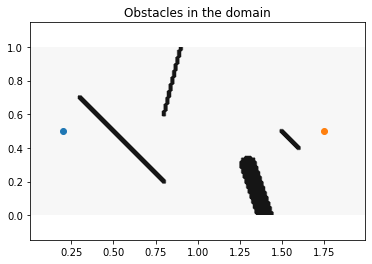

In [11]:
plt.title('Obstacles in the domain')
plt.contourf(*X,hfmIn['walls'],cmap='Greys')
plt.scatter(*hfmIn['seed_Unoriented'])
plt.scatter(*hfmIn['tip_Unoriented'])
plt.axis('equal');

### 1.2 Computing the minimal paths

The minimal path from the unoriented seed to the unoriented tip has arbitrary tangent at the endpoints, and does not account for a potential return trip.

In [12]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Fast marching solver completed in 3.53879 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


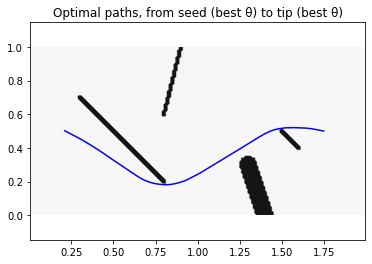

In [13]:
plt.title('Optimal paths, from seed (best θ) to tip (best θ)')
plt.contourf(*X,hfmIn['walls'],cmap='Greys')
plt.plot(*hfmOut['geodesics_Unoriented'][0][:2],'blue')
plt.axis('equal');

When the tangent at the tip is prescribed, the whole path is modified, and it may go on a different side of the obstacles.

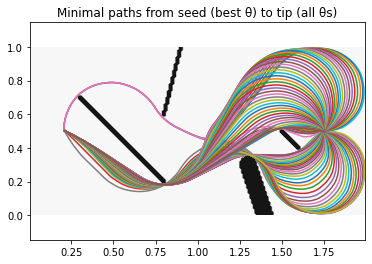

In [14]:
plt.title('Minimal paths from seed (best θ) to tip (all θs)')
plt.contourf(*X,hfmIn['walls'],cmap='Greys')
for geo in hfmOut['geodesics']: plt.plot(*geo[:2])
plt.axis('equal');

The next function performs the exhaustive minimization mentioned in the introduction, looking for the optimal tangent orientation at the intermediate keypoint. Namely
$$
    \min_{\theta_1 \in S^1} U(p_1,\theta_1) + U(q,\theta_1+\pi),
$$
where $U$ is the numerical solution to an eikonal-like equation, computed by the HFM library.

In [15]:
def ClosedPathCost(hfmIn,hfmOut):
    """
    Total cost of a closed path through the keypoint, depending on the orientation.
    """
    valuesI = UniformGridInterpolation(hfmIn.Grid(),hfmOut['values'],periodic=(False,False,True))
    tipValues = valuesI(hfmIn['tips'].T)
    return tipValues[:nθ//2] + tipValues[nθ//2:]

In [16]:
costDubins = ClosedPathCost(hfmIn,hfmOut)
iθ = int(np.argmin(costDubins))

As a function of the angle of the intermediate keypoint, the cost of the return trip is smooth except at a point, which is a local maximum. This situation is typical, since local maxima of the distance function on a given subset often (not always) correspond its intersection with the cut locus, where the distance function looses differentiability. This also means that it is easier to minimize a distance than to maximize it, which is a welcome property here, although we content ourselves with exhausive search.

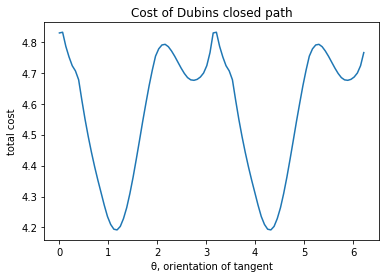

In [17]:
plt.title('Cost of Dubins closed path')
plt.plot(aΘ,np.concatenate([costDubins,costDubins]))
plt.xlabel('θ, orientation of tangent'); plt.ylabel('total cost');

Optimal paths for the Dubins model are expected to be successions of straight lines and of circle arcs matching the given bound $\xi$ on the radius of curvature. This property observed in the numerical experiment, up to discretization errors.

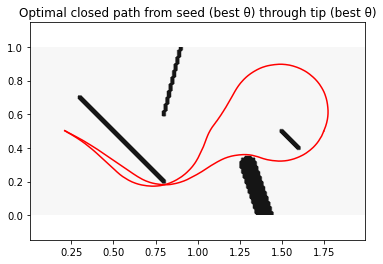

In [18]:
plt.title('Optimal closed path from seed (best θ) through tip (best θ)')
plt.contourf(*X,hfmIn['walls'],cmap='Greys')
for i in (iθ,iθ+nθ//2):
    plt.plot(*hfmOut['geodesics'][i][:2],'red')
plt.axis('equal');

### 1.3 Comparing the models

The curvature $\kappa$ of a path is penalized differently by the various non-holonomic models implemented in the HFM library. See the notebook on [curvature penalization](Curvature.ipynb) for details.

The Dubins model, considered above, imposes a strict bound $|\xi \kappa| \leq 1$, where $\xi$ is a parameter of the model. In contrast, the Euler-Mumford elastica model allows abitrary curvatures, but penalizes temp quadratically, through the cost $1+ (\xi \kappa)^2$.



In [19]:
hfmIn['model'] = 'Elastica2'
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Fast marching solver completed in 9.4513 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


In [20]:
costElastica = ClosedPathCost(hfmIn,hfmOut)
iθ = int(np.argmin(costElastica))

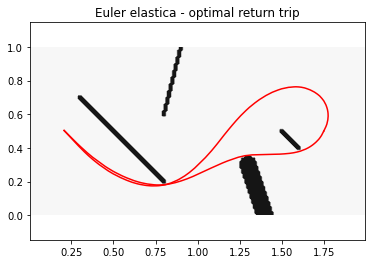

In [21]:
plt.title('Euler elastica - optimal return trip')
plt.contourf(*X,hfmIn['walls'],cmap='Greys')
for i in (iθ,iθ+nθ//2):
    plt.plot(*hfmOut['geodesics'][i][:2],'red')
plt.axis('equal');

The Reeds-Shepp forward model penalizes curvature in a quasi-linear manner, through the cost $\sqrt{1+(\xi \kappa)^2}$. In particular, in place rotations are permitted, since they correspond to a Dirac in curvature. They typically arise at the endpoints, here at the visited keypoint, and sometimes at the tips of obstacles.

In [22]:
hfmIn['model'] = 'ReedsSheppForward2'
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Fast marching solver completed in 1.08366 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


In [23]:
costReedsShepp = ClosedPathCost(hfmIn,hfmOut)
iθ = int(np.argmin(costReedsShepp))

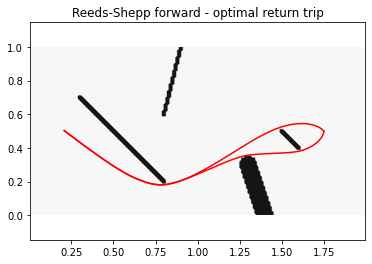

In [24]:
plt.title('Reeds-Shepp forward - optimal return trip')
plt.contourf(*X,hfmIn['walls'],cmap='Greys')
for i in (iθ,iθ+nθ//2):
    plt.plot(*hfmOut['geodesics'][i][:2],'red')
plt.axis('equal');

A specific feature of the Reeds-Shepp model, in the context of our application, is that the minimum is 'flat'. This is because the optimal path features an in-place rotation at the keypoint, and therefore the path tangent at that point is ill defined.

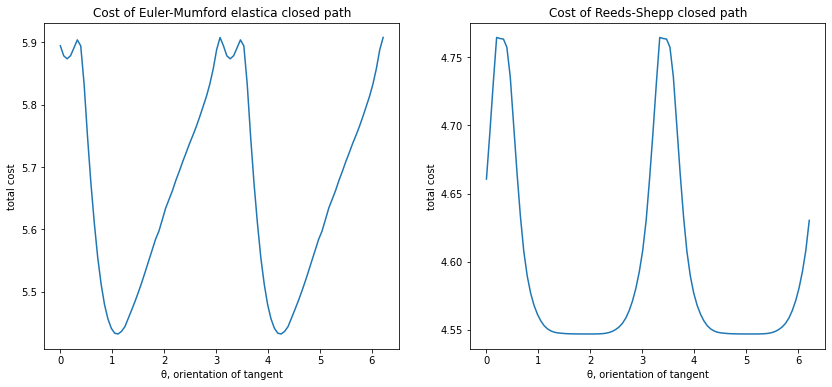

In [25]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.title('Cost of Euler-Mumford elastica closed path')
plt.plot(aΘ,np.concatenate([costElastica,costElastica]))
plt.xlabel('θ, orientation of tangent'); plt.ylabel('total cost');

plt.subplot(1,2,2)
plt.title('Cost of Reeds-Shepp closed path')
plt.plot(aΘ,np.concatenate([costReedsShepp,costReedsShepp]))
plt.xlabel('θ, orientation of tangent'); plt.ylabel('total cost');

## 2. Evading surveillance 

In this section, we consider a closed path through a empty domain equipped with surveillance devices ('radars'). Our aim is to find a closed path visiting a given keypoint, and minimizing the probability of detection. In a section step, described in the next section, we optimize the position of the radars.

### 2.1 Detection model

For simplicity, our surveillance devices are omni-directional, with a probability of detection depending only on the distance to the device location, and decreasing quadratically. We use the common simplification that the detection probabilities add up independently along the path, and with the different devices. More precisely, assuming $K$ detection devices located at $(x_k)_{k=1}^K$, the probability that a path $\gamma : [0,L] \to \Omega$, parametrized at unit Euclidean, speed evades detection is modeled as
$$
    P(\gamma) = \exp\Big[-\int_0^L \sum_{1 \leq k \leq K} \frac {\mathrm{d}l} {1+\|\gamma(l)-x_k\|^2/r^2} \Big]
$$
The purpose is to maximize $P(\gamma)$, thus to minimize the integral. In addition, the path is subject as before to a lower bound on the radius of curvature, to model the maneuverability constraints.

**More realistic detection models.**
Radars detection and furtivity is a complex and technical subject. More realistic models need to include blind spots governed by a variety of phenomena, including obstacles and valleys, and the radar internal parameters.
See the following work and references therein:
* Dreo, J., Desquilbet, F., Barbaresco, F., & Mirebeau, J.-M. (2019). Netted multi-function radars positioning and modes selection by non-holonomic fast marching computation of highest threatening trajectories. Presented at the International RADAR’19 conference.

In [26]:
def DetectionProba(q,x,r0=0.2):
    """
    Detection probability at x, from a device located at q.
    """
    q,x = fd.common_field((q,x),(1,1))
    dqx2 = ((q-x)**2).sum(axis=0) # Squared distance
    return 1./(1 + dqx2/r0**2)

We use several detection devices, located at different positions.

In [27]:
qDevice = xp.array([[0.5,0.6],[1.2,0.1],[1.4,0.7]]).T
proba = sum(DetectionProba(qi,X,0.1) for qi in qDevice.T)

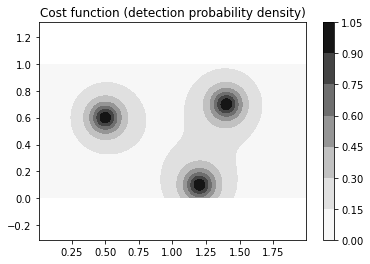

In [28]:
plt.title('Cost function (detection probability density)')
plt.contourf(*X,proba,cmap='Greys')
plt.axis('equal'); plt.colorbar();

### 2.2 Optimal path

Similarly to the obstacles setting, the optimal path is obtained by optimizing over all the possible tangent directions at the intermediate point.

In [29]:
hfmIn['model'] = 'Dubins2'
hfmIn['cost'] = proba
hfmIn.pop('walls',None);

In [30]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Fast marching solver completed in 4.42181 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


In [31]:
cost = ClosedPathCost(hfmIn,hfmOut)
iθ = int(np.argmin(cost))

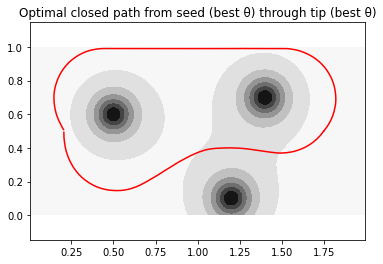

In [32]:
plt.title('Optimal closed path from seed (best θ) through tip (best θ)')
plt.contourf(*X,hfmIn['cost'],cmap='Greys')
for i in (iθ,iθ+nθ//2):
    plt.plot(*hfmOut['geodesics'][i][:2],'red')
plt.axis('equal');

As a function of the keypoint angle, the path cost has the same structure as before, with an smooth minimum, and a non-differentiable maximum.

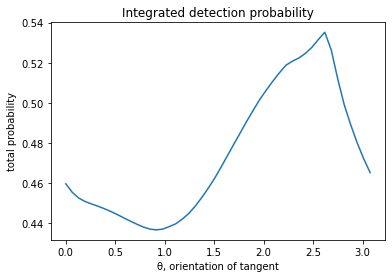

In [33]:
plt.title('Integrated detection probability')
plt.plot(aΘ[:nθ//2],cost)
plt.xlabel('θ, orientation of tangent'); plt.ylabel('total probability');

## 3 Optimization of the surveillance system

In this section, we optimize the position of a collection of surveillance devices, so as to maximize the cost of visiting a given keypoint using a closed path. We are thus effectively solving a min-max, an elementary two-player zero-sum game with complete information.
$$
    \max_{\sigma \in \Sigma} \min_{\gamma \in \Gamma} C(\sigma,\gamma),
$$
where $C(\sigma,\gamma)$ denotes the cost of path $\gamma \in \Gamma$ within a domain equipped with a surveillance system of parameters $\sigma \in \Sigma$.

**Detection model.**
We use the same detection model as in the previous section. In particular $\Gamma$ is the set of all closed paths in the domain visiting a given keypoint, and $\Sigma$ is the set of all possible radar positions. The techniques put in place in the previous section let us to compute
$$
    C(\sigma) := \min_{\gamma \in \Gamma} C(\sigma,\gamma).
$$

**Optimization w.r.t position.**
We differentiate the cost $C(\sigma)$ w.r.t the detection devices parameters, and use a gradient ascent to approximate
$$
    \max_{\sigma \in \Sigma} C(\sigma),
$$
and thus solve the original min-max problem.

Let us emphasise the $\sigma \in \Sigma \mapsto C(\sigma)$ is a non-smooth, non-convex function, with many local maxima. As a result, optimizing w.r.t $\sigma$ is a challenging problem, to which our naive gradient ascent is not the definitive answer. 

**Alternative approaches to the configuration of surveillance systems.**
A standard approach for the configuration of detection networks is to maximize the minimal (max-min) probability of detection over a set of *points*: the whole domain, or a critical subdomain such as a region border. In contrast, we here maximize the minimal probability of detection over the set of adverse trajectories visiting the keypoint to be defended.

### 3.1 Differentiation of the objective function

We rely on automatic differentiation to compute the gradient of $C(\sigma)$ w.r.t the radar position parameters $\sigma \in \Sigma$.

In [34]:
qDevice_ad = ad.Dense.identity(constant=qDevice)
proba_ad = sum(DetectionProba(qi,X,0.1) for qi in qDevice_ad.T)

At the present time, the HFM library does not not automatically broadcast AD cost information over the angular dimension, so we must do this ourselves.

In [35]:
proba_ad_broadcasted = np.broadcast_to(np.expand_dims(proba_ad,axis=-1), hfmIn.shape)

In [36]:
proba_ad.shape, proba_ad_broadcasted.shape, hfmIn.shape

((200, 100), (200, 100, 96), (200, 100, 96))

In [37]:
hfmIn['cost'] = proba_ad_broadcasted

In [38]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Fast marching solver completed in 5.82681 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


In [39]:
cost = ClosedPathCost(hfmIn,hfmOut)
iθ = int(np.argmin(cost))

The computed cost zero-th order value is the same as before, but we now also get a first order value: the gradient of the cost of the optimal closed path w.r.t the detection devices positions.

In [40]:
qDevice_grad = cost[iθ].gradient().reshape(qDevice.shape)

The gradient component is for moving the bottom detector slightly up.

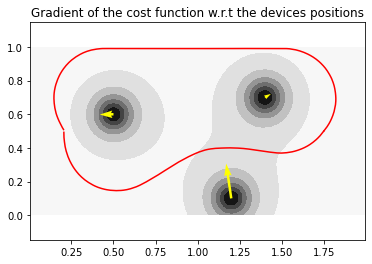

In [41]:
plt.title('Gradient of the cost function w.r.t the devices positions')
plt.contourf(*X,proba,cmap='Greys')
for i in (iθ,iθ+nθ//2):
    plt.plot(*hfmOut['geodesics'][i][:2],'red')
plt.quiver(*qDevice,*qDevice_grad,color='yellow')
plt.axis('equal');

### 3.2 Soft minimum

The objective function
$$
    C(\sigma) := \min_{\gamma \in \Gamma} C(\sigma,\gamma),
$$
is non-differentiable, non convex, and non-smooth, which will raise a number of difficulties in the subsequent optimization routine. 
In order to tame these issues, we replace the hard minimum with a soft-minimum. 

More precisely, we group the paths depending on the orientation $\theta \in S^1$ of their tangent at the keypoint, introducing
$$
    C (\sigma,\theta) := \min_{\gamma \in \Gamma_\theta} C(\sigma,\gamma).
$$
Then compute a soft minimum, depending on a relaxation parameter $\epsilon>0$
$$
    C_\epsilon(\sigma) := \min^\epsilon_{1 \leq i \leq N} C(\sigma,\theta_i),
$$
where $\theta_i \in S^1$, $1 \leq i \leq N$, denote all the discretized orientations of the tangent at the keypoint.

Recall that the soft minimum of a family of values $(a_i)_{1 \leq i \leq N}$, where $\epsilon>0$ is a relaxation parameter, is defined as 
$$
    \min_{1 \leq i \leq N}^\epsilon a_i := -\epsilon \ln \Big[ \frac 1 N \sum_{1 \leq i \leq N} \exp(-\frac {a_i} \epsilon) \Big].
$$

In [42]:
def softMin(arr,ϵ=0.01): return -ϵ * np.log(np.mean(np.exp(-arr/ϵ)))

It is also interesting to visualize all the possible paths weighted by their contribution in the soft-min. Only the most important contributions are visible.

In [43]:
def softWeights(arr,ϵ=0.01): 
    arrmin = np.min(arr)
    return np.exp((arrmin-arr)/ϵ)

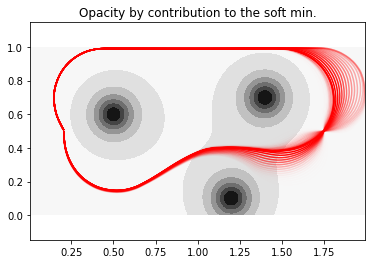

In [44]:
plt.title('Opacity by contribution to the soft min.')
plt.contourf(*X,proba,cmap='Greys')
for i,c in enumerate(softWeights(cost.value)):
    c=float(c) # GPU compatibility
    plt.plot(*hfmOut['geodesics'][i][:2],'red',alpha=c)
    plt.plot(*hfmOut['geodesics'][i+nθ//2][:2],'red',alpha=c)
plt.axis('equal');

### 3.3 Optimization

We use a projected gradient ascent, constraining the radar horizontal positions to lie within a subdomain. This is to avoid locating the radars outside of the domain, or on top of the seed or intermediate keypoint (which is not a very interesting solution).

In [45]:
def project(q):
    """
    Project detection device position within acceptable subdomain.
    """
    q = q.copy()
    q[0] = np.minimum(1.6,np.maximum(0.4,q[0]))
    q[1] = np.minimum(1. ,np.maximum(0. ,q[1]))
    return q

In [46]:
def CostFromPos(qDevice):
    """
    Closed path costs as a function of detection devices positions.
    """
    # Prepare the detection probability density
    proba = sum(DetectionProba(qi,X,0.1) for qi in qDevice.T)
    proba_broadcasted = np.broadcast_to(np.expand_dims(proba,axis=-1), hfmIn.shape)

    # Solve the eikonal equation
    hfmIn['cost'] = proba_broadcasted
    hfmOut = hfmIn.Run()
    
    # Get the soft-min cost of the closed paths 
    return ClosedPathCost(hfmIn,hfmOut),hfmIn,hfmOut

Now, run a gradient ascent. We limit ourselves to a few iterations, with a fixed gradient step. 
For a practical application, it is necessary to use more optimization steps, and possibly a better optimization routine, featuring e.g line search. 

Done iteration 1/6


Done iteration 2/6


Done iteration 3/6


Done iteration 4/6


Done iteration 5/6


Done iteration 6/6


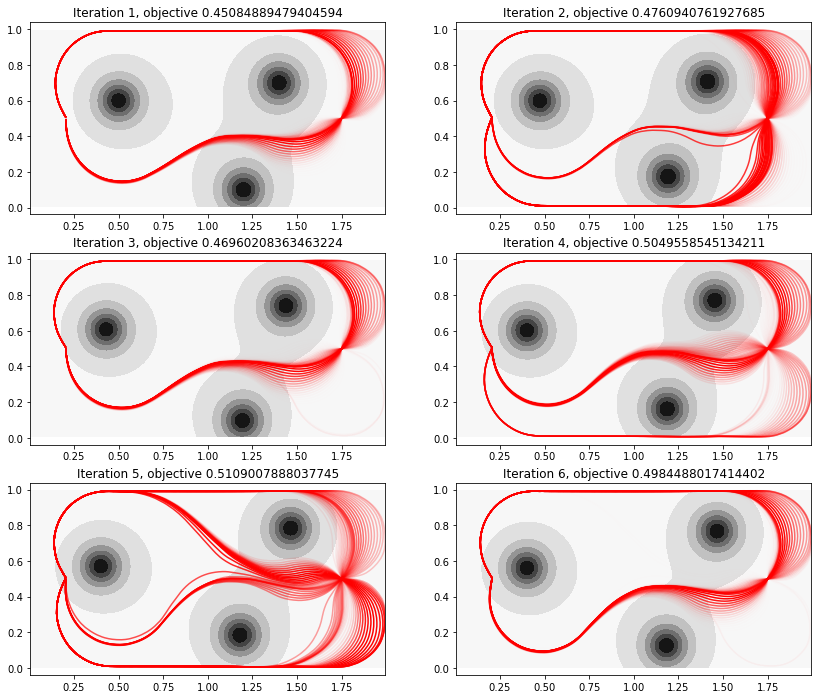

In [47]:
# May take a minute to execute
nx,ny = 2,3 # Number of iterations (hence also figures)
plt.figure(figsize=[14,4*ny])

q_opt = qDevice.copy() # Starting point of iteration
hist=[] # History of inputs/values
rgrad = 0.2 # gradient step
hfmIn['verbosity']=0

for i in range(1,1+nx*ny):
    cost_ad,hfmIn,hfmOut = CostFromPos(ad.Dense.identity(constant=q_opt))
    hist.append((q_opt,cost_ad))
    cmin_ad = softMin(cost_ad)
    grad = cmin_ad.gradient().reshape(q_opt.shape)
    q_opt = project(q_opt+rgrad*grad)
    
    print(f"Done iteration {i}/{nx*ny}")
    plt.subplot(ny,nx,i)
    plt.title(f"Iteration {i}, objective {cmin_ad.value}")
    plt.contourf(*X,hfmIn['cost'].value[:,:,0],cmap='Greys')
    for j,c in enumerate(softWeights(cost_ad.value)):
        c=float(c) # GPU compatibility
        plt.plot(*hfmOut['geodesics'][j][:2],'red',alpha=c)
        plt.plot(*hfmOut['geodesics'][j+nθ//2][:2],'red',alpha=c)
    plt.axis('equal');

We display below the evolution of the position of the three detectors along the iterations. Note, again, that the optimization is not finalized. We have the following comments:
* Optimizing the position of the bottom detector is quite hard, and it seems to oscillate between the iterations. Indeed this detector tries to position itself so as to divide the trajectories in two sets, above and below itself.
* The other two detectors have simpler trajectories. In particular, the left detector seems is moving toward the lower bound $x=0.4$ on the horizontal position.

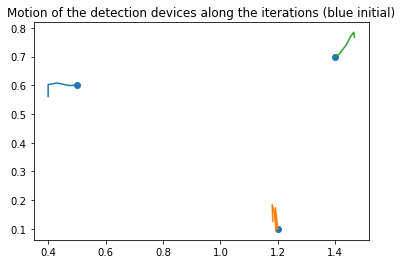

In [48]:
q_hist = ad.array([q for (q,_) in hist])
plt.title("Motion of the detection devices along the iterations (blue initial)")
plt.plot(*np.moveaxis(q_hist,0,1))
plt.scatter(*qDevice)
plt.axis('equal');

An interesting side effect of the optimization of the detectors positions is that there is not a single best adverse trajectory, but several almost optimal trajectories. Here, this is especially visible in iteration $5$, where the highest value of the objective function is attained (this value decreases a bit in iteration $6$, recall that the optimization procedure has not reached convergence yet). 

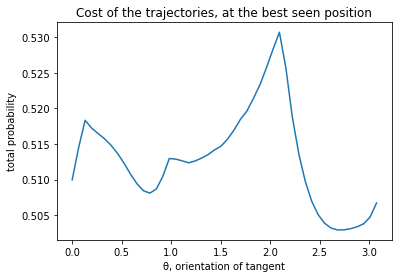

In [49]:
plt.title("Cost of the trajectories, at the best seen position")
plt.plot(aΘ[:nθ//2],hist[-2][1].value);
plt.xlabel('θ, orientation of tangent'); plt.ylabel('total probability');

### 3.4 Different initial conditions

The objective function, the probability of detection of the most furtive trajectory, is non-smooth and highly non-linear w.r.t the detection device parameters. Thus is is not surprising that a different initial configuration leads the optimization procedure to select a distinct local optimum. We illustrate this instable behavior by shifting one of the detectors to the right initially.

In [50]:
qDevice2 = qDevice.copy()
qDevice2[0,0]=1 # Moved first detector to the right
proba = sum(DetectionProba(qi,X,0.1) for qi in qDevice2.T)

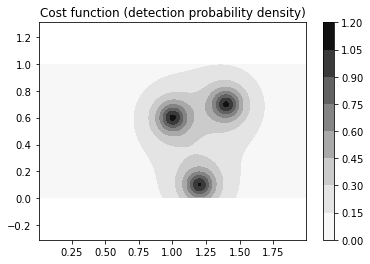

In [51]:
plt.title('Cost function (detection probability density)')
plt.contourf(*X,proba,cmap='Greys')
plt.axis('equal'); plt.colorbar();

As before, we run a few steps of projected gradient ascent. Again, we must emphasize that a more sophisticated optimization routine, running for a longer time, is necessary to property optimize this non-convex and non-smooth objective function.

Done iteration 1/6


Done iteration 2/6


Done iteration 3/6


Done iteration 4/6


Done iteration 5/6


Done iteration 6/6


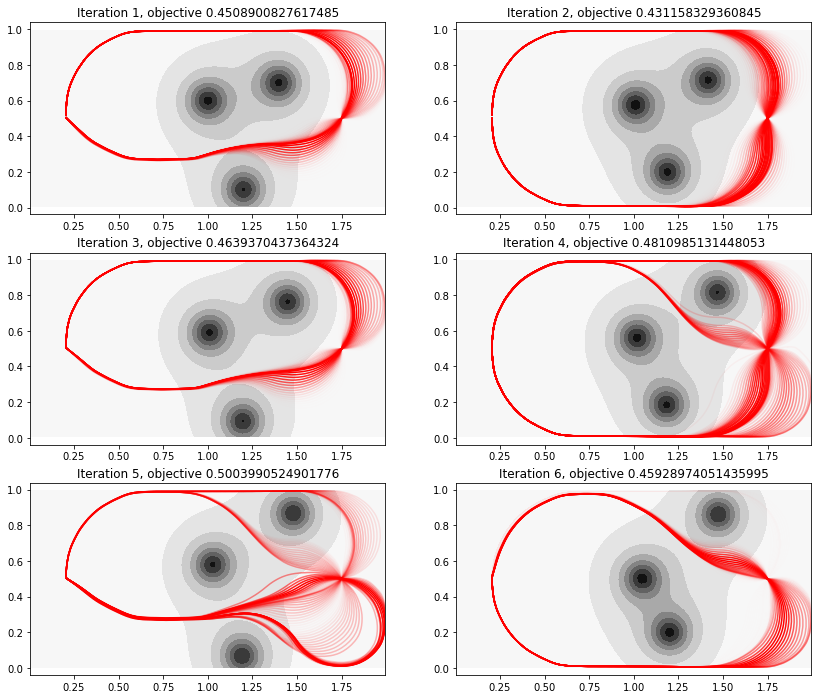

In [52]:
# May take a minute to execute
nx,ny = 2,3 # Number of figures/iterations
plt.figure(figsize=[14,4*ny])

q_opt = qDevice2.copy() # Starting point of iteration
hist=[] # History of inputs/values
rgrad = 0.2 # gradient step
hfmIn['verbosity']=0

for i in range(1,1+nx*ny):
    cost_ad,hfmIn,hfmOut = CostFromPos(ad.Dense.identity(constant=q_opt))
    hist.append((q_opt,cost_ad))
    cmin_ad = softMin(cost_ad)
    grad = cmin_ad.gradient().reshape(q_opt.shape)
    q_opt = project(q_opt+rgrad*grad)
    
    print(f"Done iteration {i}/{nx*ny}")
    plt.subplot(ny,nx,i)
    plt.title(f"Iteration {i}, objective {cmin_ad.value}")
    plt.contourf(*X,hfmIn['cost'].value[:,:,0],cmap='Greys')
    for j,c in enumerate(softWeights(cost_ad.value)):
        c=float(c)
        plt.plot(*hfmOut['geodesics'][j][:2],'red',alpha=c)
        plt.plot(*hfmOut['geodesics'][j+nθ//2][:2],'red',alpha=c)
    plt.axis('equal');

The best value of the objective is, as before, achieved in the fifth iteration when the detectors are placed so that there are multiple distinct equally optimal trajectories.

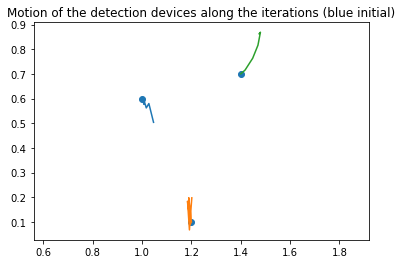

In [53]:
q_hist = ad.array([q for (q,_) in hist])
plt.title("Motion of the detection devices along the iterations (blue initial)")
plt.plot(*np.moveaxis(q_hist,0,1))
plt.scatter(*qDevice2)
plt.axis('equal');